# Basic Eventador Report

Goal: to set up a simple eventador report with basic indicators on tweets. Should be the base for the later, more complicated analytics pipeline.

## Example Eventador NB from @asragab

In [1]:
from kafka import KafkaConsumer
import uuid
import json

In [3]:
consumer = KafkaConsumer(bootstrap_servers='e143b95e-kafka0.pub.or.eventador.io:9092', 
                         value_deserializer=lambda s: json.loads(s, encoding='utf-8'), 
                         auto_offset_reset='smallest', 
                         group_id=uuid.uuid4()) 

In [4]:
consumer.subscribe(['tweets'])

In [5]:
limit = 500
consumer.poll(max_records=limit)
count = 0
data = []
for msg in consumer:
    data.append(msg.value)
    count += 1
    if count >= limit:
        break

In [6]:
len(data)

500

## Simple graph analytics for the Twitter stream
For this first step we want:
- top 10 retweeted users
- top 10 PageRanked users
- basic matplotlib viz

In [ ]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

### Building the directed graph
We build the retweet graph, where an edge is from the original tweeter to the retweeter. We add node weights corresponding to how much each node was retweeted

In [144]:
graph = nx.DiGraph()

In [145]:
for tweet in data:
    if tweet.get('retweet') == 'Y':
        name = tweet.get('name')
        original_name = tweet.get('original_name')
        followers = tweet.get('followers')
        if name not in graph: graph.add_node(name, retweets = 0)
        if original_name not in graph: 
            graph.add_node(original_name, retweets = 1)
        else:
            graph.node[original_name]['retweets'] = graph.node[original_name]['retweets'] +1
        graph.add_edge(original_name, name)    


### Most retweeted users

In [157]:
top10_retweets = sorted([(node,graph.node[node]['retweets']) for node in graph.nodes()], key = lambda x: -x[1])[0:10]
top10_retweets

[(u'George Takei', 63),
 (u'Ashley Feinberg', 18),
 (u'Sleeping Giants', 14),
 (u'Lou Dobbs', 8),
 (u'Linda Suhler, Ph.D.', 7),
 (u'Keith Olbermann', 7),
 (u'Mike Cernovich \U0001f1fa\U0001f1f8', 7),
 (u'Donald Trump Jr.', 6),
 (u'Andy Richter', 5),
 (u'Bill Mitchell', 4)]

### Top 10 Pageranked users
Note - these are the 'archetypal retweeters' of the graph (well, not exactly. see https://en.wikipedia.org/wiki/PageRank)

In [158]:
pr = nx.pagerank(graph)
colors = [pr[node] for node in graph.nodes()]
top10_pr = sorted([(k,v) for k,v in pr.items()], key = lambda x: x[1])[0:10]
label_dict = dict([(k[0],k[0]) for k in top10_pr])
top10_pr

[(u'Rebellion Report', 0.0014492869546939122),
 (u'Fredra Kodama', 0.0014492869546939122),
 (u'Sean Spicer', 0.0014492869546939122),
 (u'Bill Mitchell', 0.0014492869546939122),
 (u"Donald's Angel", 0.0014492869546939122),
 (u'libby', 0.0014492869546939122),
 (u'Malik Obama', 0.0014492869546939122),
 (u'Michelle Lucille\U0001f1fa\U0001f1f8', 0.0014492869546939122),
 (u'Vegas4Trump', 0.0014492869546939122),
 (u'Thomas P Kennedy III', 0.0014492869546939122)]

### Basic network viz
- size of nodes is number of retweets
- color of nodes is pagerank
- we only label the top 10 pageranked users

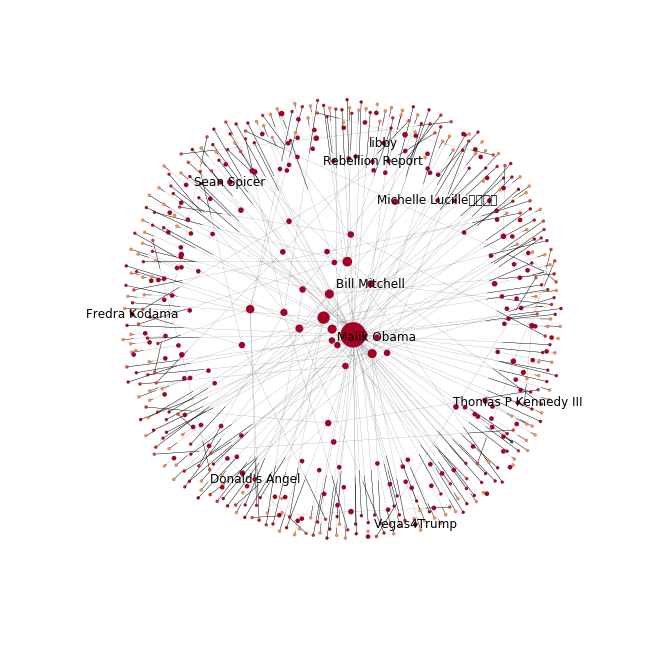

In [147]:
plt.figure(figsize=(11,11))
plt.axis('off')
weights = [10*(graph.node[node]['retweets'] + 1) for node in graph.nodes()]
nx.draw_networkx(graph, node_size = weights,  width = .1, linewidths = .1, with_labels=True,
                 node_color = colors, cmap = 'RdYlBu', 
                 labels = label_dict)

In [159]:
consumer.close()

ERROR:kafka.coordinator:Heartbeat session expired - marking coordinator dead
ERROR:kafka.conn:<BrokerConnection host=e143b95e-kafka0.pub.or.eventador.io/35.167.53.34 port=9092>: socket disconnected
ERROR:kafka.coordinator:Error sending OffsetCommitRequest_v2 to node 1001 [ConnectionError: socket disconnected]
ERROR:kafka.coordinator:Error sending GroupCoordinatorRequest_v0 to node 1001 [NodeNotReadyError: 1001]
ERROR:kafka.coordinator.consumer:Offset commit failed: This is likely to cause duplicate message delivery
Traceback (most recent call last):
  File "/Users/henripal/miniconda3/envs/py27/lib/python2.7/site-packages/kafka/coordinator/consumer.py", line 394, in _maybe_auto_commit_offsets_sync
    self.commit_offsets_sync(self._subscription.all_consumed_offsets())
  File "/Users/henripal/miniconda3/envs/py27/lib/python2.7/site-packages/kafka/coordinator/consumer.py", line 385, in commit_offsets_sync
    raise future.exception # pylint: disable-msg=raising-bad-type
CommitFailedError: